In [33]:
import torch
print("cuDNN available:", torch.backends.cudnn.is_available())
print("cuDNN version:", torch.backends.cudnn.version())
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())


cuDNN available: True
cuDNN version: 8902
2.3.0+cu121
12.1
8902


In [34]:
import os
import re
import gc
import sys
import time
import random
import csv
import shutil
import pathlib
import pickle
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit, cuda
from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import AdamW
from torchvision import models, transforms

import timm

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger

from torchmetrics import Metric, F1Score
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from tqdm.notebook import tqdm

import json

In [35]:

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training")

# Path to the images and CSV file
img_dir = './data/images'
train_file = './data/train_binarized.csv'
test_file = './data/test.csv'

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file, usecols=['ImageID'])
train_df





Using cuda for training


,ImageID,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19
0,0.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3.jpg,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,4.jpg,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995.jpg,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
29996,29996.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29997,29997.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29998,29998.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
import os
class ImageDataset(Dataset):
    def __init__(self,df, img_dir, transform=None):
        self.df=df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx,0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        labels = self.df.iloc[idx, 1:19].values.astype('float')
        
        if self.transform:
            image = self.transform(image)
        
        return img_name,image, labels

# Transformations for the images

transform = transforms.Compose([
    transforms.Resize((224,224)),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])



In [37]:
from sklearn.model_selection import train_test_split

train_set , val_set = train_test_split(train_df,test_size = 0.3)


train_dataset = ImageDataset(train_set,img_dir=img_dir, transform=transform)
val_dataset = ImageDataset(val_set,img_dir=img_dir, transform=transform)
test_dataset = ImageDataset(test_df,img_dir=img_dir, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = 32,
                                               shuffle = True,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size = 32,
                                               shuffle = False,num_workers=15)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size = 1,
                                               shuffle = False,num_workers=15)



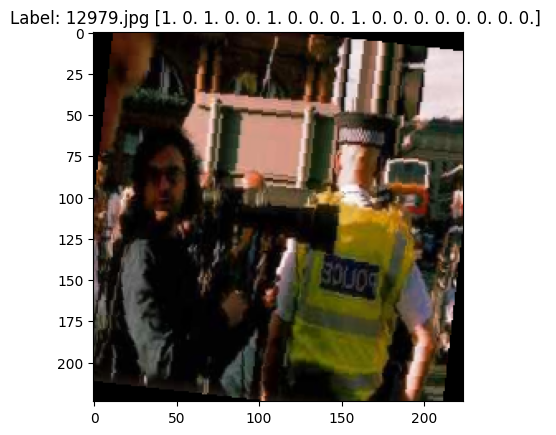

In [38]:
import torchvision.transforms.functional as F

image_name,image, label = train_dataset[0]  

image = F.to_pil_image(image)
print()
# Display the image
plt.imshow(image)
plt.title(f'Label: {image_name} {label} ')
plt.show()

In [39]:

timm.list_models("resnet*")

['resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50c',
 'resnet50d',
 'resnet50s',
 'resnet50t',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101c',
 'resnet101d',
 'resnet101s',
 'resnet152',
 'resnet152c',
 'resnet152d',
 'resnet152s',
 'resnet200',
 'resnet200d',
 'resnetaa34d',
 'resnetaa50',
 'resnetaa50d',
 'resnetaa101d',
 'resnetblur18',
 'resnetblur50',
 'resnetblur50d',
 'resnetblur101d',
 'resnetrs50',
 'resnetrs101',
 'resnetrs152',
 'resnetrs200',
 'resnetrs270',
 'resnetrs350',
 'resnetrs420',
 'resnetv2_50',
 'resnetv2_50d',
 'resnetv2_50d_evos',
 'resnetv2_50d_frn',
 'resnetv2_50d_gn',
 'resnetv2_50t',
 'resnetv2_50x1_bit',
 'resnetv2_50x3_bit',
 'resnetv2_101',
 'resnetv2_101d',
 'resnetv2_101x1_bit',
 'resnetv2_101x3_bit',
 'resnetv2_152',
 'resnetv2_152d',
 'resnetv2_152x2_bit',
 'resnetv2_152x4_bit']

In [40]:
timm.list_models("resnetv2*")

['resnetv2_50',
 'resnetv2_50d',
 'resnetv2_50d_evos',
 'resnetv2_50d_frn',
 'resnetv2_50d_gn',
 'resnetv2_50t',
 'resnetv2_50x1_bit',
 'resnetv2_50x3_bit',
 'resnetv2_101',
 'resnetv2_101d',
 'resnetv2_101x1_bit',
 'resnetv2_101x3_bit',
 'resnetv2_152',
 'resnetv2_152d',
 'resnetv2_152x2_bit',
 'resnetv2_152x4_bit']

In [41]:


# backbone = timm.create_model("resnetv2_50",pretrained=True,num_classes = 0)
backbone = timm.create_model("resnet18",pretrained=True)
backbone.reset_classifier(0)  
backbone


# Model Definition
class MLCNNet(nn.Module):
    def __init__(self, backbone, n_classes):
        super(MLCNNet, self).__init__()
        self.model = backbone
        self.classifier = nn.Sequential(
            nn.Linear(512, 32),
            nn.BatchNorm1d(32),  
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(32, n_classes)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x
Model = MLCNNet(backbone,18)


In [42]:
import torch.nn.functional as F

class LitMLCNet(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.f1_score = F1Score(num_labels=18, average='macro', task='multilabel')

    def forward(self, x):
        print(x.shape)
        return self.model(x)

    def training_step(self, batch, batch_idx):
        img_name, x, y = batch
        logits = self.model(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        # Calculate F1 Score
        f1 = self.f1_score(logits.sigmoid(), y.int())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'f1': f1}

    def validation_step(self, batch, batch_idx):
        img_name, x, y = batch
        logits = self.model(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        f1 = self.f1_score(logits.sigmoid(), y.int())
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_f1', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {'val_loss': loss, 'val_f1': f1}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        img_name, x, _ = batch  
        preds = self.forward(x)
        return preds, img_name




In [44]:
pl_Model = LitMLCNet(Model)


weights_path = './models/resnet18_100e.pth'
pl_Model.load_state_dict(torch.load(weights_path))

trainer = pl.Trainer()

#Uncomment if training model 

# trainer = pl.Trainer(
#     default_root_dir='./',
#     max_epochs=20,  # Increased epochs
#     log_every_n_steps=5,
#     accelerator='gpu',
#     devices=1,
#     logger=True
# )

# trainer.fit(pl_Model,
#             train_dataloader,
#             val_dataloader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [45]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [46]:
preds_labels = trainer.predict(pl_Model, dataloaders=test_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1,

In [47]:

def process_and_save_predictions(preds_labels):
    with open('./predictions/resnet_predictions.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['ImageId', 'Labels'])  

        for preds, img_names in preds_labels:
            for pred, img_name in zip(preds, img_names):
                # Convert predictions from one-hot to list of labels
                pred = torch.round(torch.sigmoid(pred))  
                label_indices = pred.nonzero(as_tuple=True)[0]
                labels = ' '.join(str(label_index.item() + 1) for label_index in label_indices)
                writer.writerow([img_name, labels])


process_and_save_predictions(preds_labels)


In [48]:
predictions = []
for preds, img_names in preds_labels:
        for pred, img_name in zip(preds, img_names):
          predictions.append(torch.sigmoid(pred))

predictions = [tensor.tolist() for tensor in predictions]

with open('./processed-data/rawPredictions-resnet.json', 'w', encoding='utf-8') as f:
    json.dump(predictions, f, ensure_ascii=False, indent=4)